want to roll a FWTD. Will stick a FWTD at both ends of a rigid beam that can rotate freely

### Preamble

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels as fm
import FwtModels.dof2 as dof2
import FwtModels.RollingModel as rm
import FwtModels.AeroModels as ams

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [2]:
half = sym.Rational(1,2)

p = fm.FwtParameters(4)

# fwt params
p.Lambda = fm.FwtVariable(np.deg2rad(10),'Lambda') # flare angle
p.y_f = fm.FwtVariable(0,'y_f') # spanwise location
    
# Attitude Parmas
p.rho = fm.FwtVariable(1.225,'rho') # density
p.V = fm.FwtVariable(10,'V') # velocity
p.g  = fm.FwtVariable(9.81,'g') # gravity
p.alpha_r = fm.FwtVariable(np.deg2rad(3),'alpha_r') # root AoA

# Main Wing Parameter
p.a_w = fm.FwtVariable(2*np.pi,'a_w') # C_L of wing
p.y_w = fm.FwtVariable(0,'y_w') # spanwise location


# Create some global parameters
p.c = fm.FwtVariable(0.15,'c') # chord of wing
p.m_t = fm.FwtVariable(30,'m_t') # wing total mass
p.s_t = fm.FwtVariable(10,'s_t') # wing total span
p.sigma = fm.FwtVariable(0.2,'sigma') # FWT as percentage of total span
p.f = fm.FwtVariable(2,'f') # initial freqency


# Set dependent expressions
p.m_w = p.m_t*(sym.Integer(1)-p.sigma) # mass of inner wing
p.s_w = p.s_t*(sym.Integer(1)-p.sigma) # span of main wing
p.m_f = p.m_t*p.sigma*half # mass of each FWT
p.s_f = p.s_t*p.sigma*half # span of each FWT

p.a_f = p.a_w - p.a_w*p.y_f/p.s_f

p.I_xx_f = sym.Rational(1,12)*p.m_f*p.s_f**2 # inertia of FWT (uniform bar)
p.I_xx_w = sym.Rational(1,12)*p.m_w*p.s_w**2 # inertia of wing (uniform bar)
p.l_f = p.s_f*half # location of FWT CoM from Hinge
p.l_w = p.s_w*half # location of main wing CoM

p.k_w = (p.f*2*sym.pi)**2*(p.m_t) # set inner wing Freq to inner_freq

#### Create Transforms

system has 3 degrees of freedom:

q[0] - rotation about the base of the spring (roll)
q[1] - plunging motion
q[2] - FWT fold angle



In [3]:
wing_frame = symt.HomogenousTransform().R_x(p.q[0]).Translate(0,0,p.q[1]).R_y(p.alpha_r)

rhs_fwt_frame = wing_frame.Translate(0,p.s_w*half,0).R_x(p.q[2])  # RHS Fwt Frame
lhs_fwt_frame = wing_frame.Translate(0,-p.s_w*half,0).R_x(-p.q[3])  # RHS Fwt Frame

rot_rhs = sym.Matrix([p.q[0]+p.q[2],p.alpha_r,0])
rot_lhs = sym.Matrix([p.q[0]-p.q[3],p.alpha_r,0])
wing_rot = sym.Matrix([p.q[0],p.alpha_r,0])


M_fwt = fm.MassMatrix(p.m_f,I_xx = p.I_xx_f)
M_w = fm.MassMatrix(p.m_w,I_xx = p.I_xx_w)

bar_fwt_rhs = fm.RigidElement(rhs_fwt_frame.Translate(0,p.l_f,0),rot_rhs,M_fwt)
bar_fwt_lhs = fm.RigidElement(lhs_fwt_frame.Translate(0,-p.l_f,0),rot_lhs,M_fwt)
bar_wing = fm.RigidElement(wing_frame,wing_rot,M_w)

# Gravitational Forces
fwt_GravityForces_rhs = ams.GravityModel(p,rhs_fwt_frame.Translate(0,p.l_f,0),sym.Matrix([0,0,p.g*p.m_f]))
fwt_GravityForces_lhs = ams.GravityModel(p,lhs_fwt_frame.Translate(0,-p.l_f,0),sym.Matrix([0,0,p.g*p.m_f]))
wing_GravityForces = ams.GravityModel(p,wing_frame,sym.Matrix([0,0,p.g*p.m_w]))

#Aero Forces
rhs_fwt_AeroForces = ams.AeroModelv2(p,rhs_fwt_frame.Translate(0,p.y_f,0),p.a_f,(p.y_f,0,p.s_f),ams.FwtAoA(p,p.q[2]))
lhs_fwt_AeroForces = ams.AeroModelv2(p,lhs_fwt_frame.Translate(0,-p.y_f,0),p.a_f,(p.y_f,0,p.s_f),ams.FwtAoA(p,p.q[3]))

wing_frame_aero = wing_frame.Translate(0,p.y_w,0)
wing_AeroForces = ams.AeroModelv2(p,wing_frame_aero,p.a_w,(p.y_w,-p.s_w*half,p.s_w*half))

#compistie force
CompositeForce = ams.CompositeForce(p,[fwt_GravityForces_rhs,fwt_GravityForces_lhs,
                                     rhs_fwt_AeroForces,lhs_fwt_AeroForces,
                                     wing_GravityForces,wing_AeroForces])
# potential energy
U = half*p.k_w*(p.q[1])**2

In [4]:
# create instance of the model
sm = rm.SymbolicModel(U,[bar_fwt_rhs,bar_fwt_lhs,bar_wing],p,ExtForces = CompositeForce)

## create masses 

In [24]:
tmax, dt = 100, 0.01
# Initial conditions: theta, dtheta/dt, L, dL/dt

#params = p.GetNumericTuple()

#set velocity and alpha_r funcs
def Vfunc(t,x):
    return 0

def arfunc(t,x):
    return np.deg2rad(2)
    #return np.deg2rad(5)+np.sin(2*np.pi*1*t)*np.deg2rad(5)

p.V.value = Vfunc
p.alpha_r.value = arfunc

y0 = [0.1,0,0,0,1,0,1,0]
#y0 = [1.5,0,0.02,0]
ts = np.arange(0, tmax+dt, dt)

constraints = [np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN]

def objectiveDeriv(t,y):
    deriv = sm.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(np.isnan(constraints),deriv,constraints))

In [25]:
objectiveDeriv(0,[0,0,0,0,1,0,1,0])


Text(0.5, 0, 't [s]')

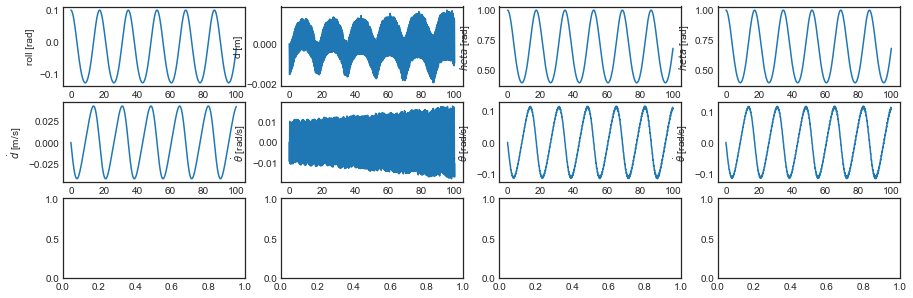

In [26]:
yData = solve_ivp(objectiveDeriv,(0,tmax),y0)

# interpolate data onto a uniform time grid

yi = yData.y
t = yData.t

plt.style.use('seaborn-white')
    
fig, axes = plt.subplots(3,4,figsize=(15,5))

# roll plot
axes[0][0].plot(t,yi[0])
axes[0][0].set_ylabel('roll [rad]')
axes[0][0].set_xlabel('t [s]')

# d plot
axes[0][1].plot(t,yi[2])
axes[0][1].set_ylabel('d [m]')
axes[0][1].set_xlabel('t [s]')

# theta plot
axes[0][2].plot(t,yi[4])
axes[0][2].set_ylabel('$\theta$ [rad]')
axes[0][2].set_xlabel('t [s]')


# theta plot
axes[0][3].plot(t,yi[6])
axes[0][3].set_ylabel('$\theta$ [rad]')
axes[0][3].set_xlabel('t [s]')

# ddot plot
axes[1][0].plot(t,yi[1])
axes[1][0].set_ylabel('$\dot{d}$ [m/s]')
axes[1][0].set_xlabel('t [s]')

# thetadot plot
axes[1][1].plot(t,yi[3])
axes[1][1].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][1].set_xlabel('t [s]')

# thetadot plot
axes[1][2].plot(t,yi[5])
axes[1][2].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][2].set_xlabel('t [s]')
# thetadot plot
axes[1][3].plot(t,yi[7])
axes[1][3].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][3].set_xlabel('t [s]')